<a href="https://colab.research.google.com/github/junjunmeng/Data-structure-and-Algo/blob/main/ddPCR_BioRad_Jun_Meng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part A

Your Assignment: Briefly describe how you would assess the quality of the data and any initial descriptive analyses you would do to get an understanding of the data. Feel free to either describe with words or by writing code to assess the quality and do the descriptive analyses.


In order to assess the quality of data, some steps will helps

1. overall profile of the descriptive analysis by pandas profiling
2. Identify outlier droplets, the outlier was identified by boxplot
3. Indentify empty droplets, droplets with very low fluorescent signal in both channels are assumed to be empty droplets. 

In [ ]:
assay_result = pd.read_csv("/content/drive/MyDrive/03- Interview-Haiyang-Jun/Take Home Assignments/Bio-Rad/assay_results.csv")
assay_result['Cluster_labels']= assay_result['Cluster_labels'].astype(str)

In [ ]:
def initial_analysis(df):
    """
    Given a dataframe produces a simple report on initial data analytics
    Params:
        - df 
    Returns:
        - Shape of dataframe records and columns
        - Columns and data types
    """
    print('Report of Initial Data Analysis:\n')
    print(f'Shape of dataframe: {df.shape}')
    print(f'Features and Data Types: \n {df.dtypes}')
    print("DataFrame Row Number: ", df.shape[0])
    #print("Unique IDs: ", df.ID.nunique())

In [ ]:
initial_analysis(assay_result)

Report of Initial Data Analysis:

Shape of dataframe: (93524, 4)
Features and Data Types: 
 Ch1               float64
Ch2               float64
Cluster_labels     object
Sample             object
dtype: object
DataFrame Row Number:  93524


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


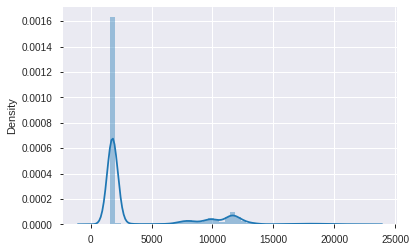

In [ ]:
sns.distplot(x= assay_result['Ch1'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


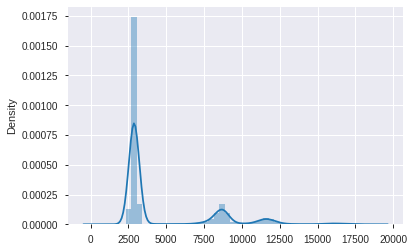

In [ ]:
sns.distplot(x= assay_result['Ch2'])

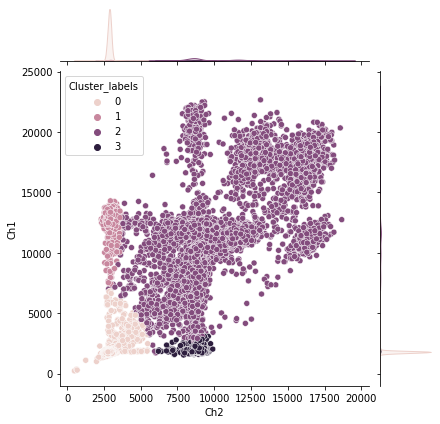

In [ ]:
sns.jointplot(data = assay_result, x = 'Ch2', y = 'Ch1', hue = 'Cluster_labels', kind = 'scatter')

#### 1.2 Remove empty droplets

In [ ]:
# get the mean and standard deviation of Ch1 and Ch2 to set the threshold of the empty droplet by threshold = mean - 5*sd

ch1_low_mean = assay_result.query("Ch1 < 5000")['Ch1'].mean()
ch1_low_sd = assay_result.query("Ch1 < 5000")['Ch1'].std()
ch1_cutoff = ch1_low_mean - 5*ch1_low_sd 

ch2_low_mean = assay_result.query("Ch2 < 5000")['Ch2'].mean()
ch2_low_sd = assay_result.query("Ch2 < 5000")['Ch2'].std()
ch2_cutoff = ch2_low_mean - 5*ch2_low_sd 

print(ch2_cutoff)
print(ch1_cutoff)

2084.8858527477396
816.9150148353532


In [ ]:
# remove empty droplet with threshold of ch1 or ch2 

assay_result.query("Ch1 < @ch1_cutoff or Ch2 < @ch2_cutoff ")

,Ch1,Ch2,Cluster_labels,Sample
8968,1206.5080,2044.6650,0,F03
20292,1256.9520,2067.8960,0,B01
44696,221.5946,502.6503,0,C03
61294,355.4171,645.8557,0,C02
72722,999.0161,1999.7970,0,B01
73472,286.3638,686.8870,0,E02
74168,1100.0240,1265.5780,0,C02


In [ ]:
assay_result_empty_removed = assay_result.query("Ch1 >= @ch1_cutoff or Ch2 >= @ch2_cutoff ")

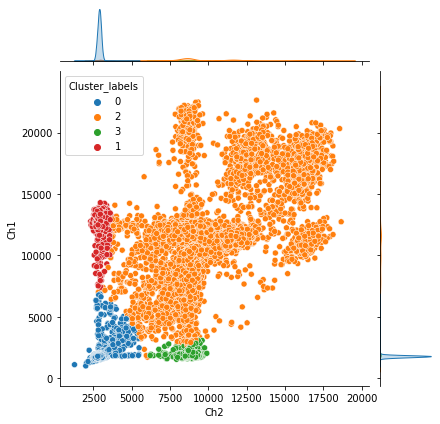

In [ ]:
sns.jointplot(data = assay_result_empty_removed, x = 'Ch2', y = 'Ch1', hue = 'Cluster_labels', kind = 'scatter')

#### 1.3 Remove outlier by boxplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


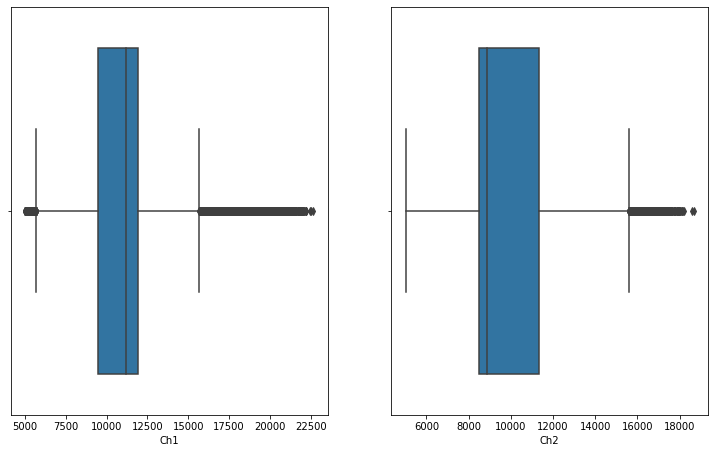

In [ ]:
# check outlier of Ch1 and Ch2
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12.5, 7.5)
sns.boxplot(assay_result_empty_removed.query("Ch1 > 5000")['Ch1'], ax = ax[0])
sns.boxplot(assay_result_empty_removed.query("Ch2 > 5000")['Ch2'], ax = ax[1])

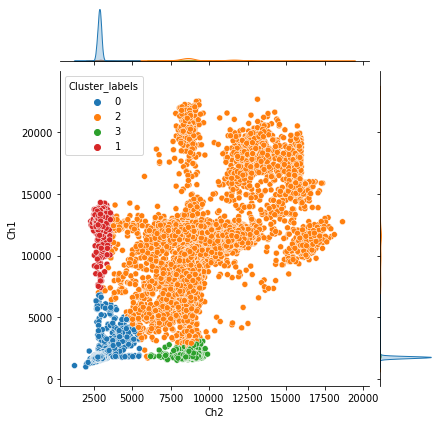

In [ ]:
# remove outlier with ch1 or ch2 > 16000 

assay_result.query("Ch1> 16000 or Ch2 > 16000")

assay_result_empty_outlier_removed = assay_result_empty_removed.query("Ch1 <= 16000 or Ch2 <= 16000")
fig.set_size_inches(12.5, 7.5)
sns.jointplot(data = assay_result_empty_outlier_removed, x = 'Ch2', y = 'Ch1', hue = 'Cluster_labels', kind = 'scatter')

## Part B 
Your Assignment: Please help us classify the droplets into their appropriate clusters to achieve high sensitivity and specificity. Please include:
1. Describe a plan to successfully automatically classify the droplets (data points) into the appropriate clusters including any data cleaning, feature extraction, classification algorithm used, and algorithm validation.
2. Perform a preliminary analysis classifying the data, possibly including plots or other visualizations and the sensitivity and specificity of the algorithm.
• Please note: feel free to reduce the dataset size to something more manageable on your computer. You do not need to perform every step you listed in question 1 above as that may be time and/or compute resource intensive.
3. Include a suggestion for an alternative algorithm you also considered and the pros and cons of the algorithm for this application.

Note: Please include your code used in the analysis to generate plots or other conclusions. This can be in any programming language of your choice. It could also be, for example, in a RMarkdown or Jupyter notebook so long as we can easily read your code.



1. The plan to automatically classify the droplets:

 - data cleaning: missing value, empty droplets, and outliers
 - classification algorithm: multi-class classifier
 - algorithm validation: cross-validation

2. Preliminary analysis was conducted by several multi-class classifiction algorithm. And the sensitivity and specificity were visualized in ROC curve. The model selection criteria including accuracy and time complexity. 

    

#### 2.1 Data prepartion for the multi-class classifier

In [ ]:
# encoding the multi-cluster

from sklearn.preprocessing import MultiLabelBinarizer
def encoding(df, col):
  mlb = MultiLabelBinarizer()
  dummies = pd.DataFrame(mlb.fit_transform(df[col]), columns= mlb.classes_, index = df.index)

  return dummies

encoding = encoding(assay_result_empty_outlier_removed, 'Cluster_labels')
assay_result_cleaned_encoding= pd.concat([assay_result_empty_outlier_removed, encoding], axis = 1)
assay_result_cleaned_encoding = assay_result_cleaned_encoding.rename(columns={"0" : "Cluster_0", "1" : "Cluster_1", "2": "Cluster_2", "3": "Cluster_3"})

assay_result_cleaned_encoding= assay_result_cleaned_encoding.drop('Cluster_labels', axis = 1)

In [ ]:
assay_result_cleaned_encoding.head(10)

,Ch1,Ch2,Sample,Cluster_0,Cluster_1,Cluster_2,Cluster_3
0,1819.749,3058.094,B03,1,0,0,0
1,1785.329,2871.747,C01,1,0,0,0
2,1686.828,2721.947,B01,1,0,0,0
3,1768.297,3080.490,B03,1,0,0,0
4,1769.638,3064.187,B03,1,0,0,0
5,1895.423,3077.842,B03,1,0,0,0
6,4735.763,6245.893,C01,0,0,1,0
7,1866.769,3101.177,E02,1,0,0,0
8,1702.510,2887.957,C01,1,0,0,0
9,1805.579,2846.766,F03,1,0,0,0


In [ ]:
# get the categories of multi labels

categories = list(assay_result_cleaned_encoding.columns.values)[3:]
print(categories)

['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']


In [ ]:
# Train-Test Split

train, test = train_test_split(assay_result_cleaned_encoding, random_state= 42, test_size = 0.30, shuffle=True)

print("The shape of train dataset is:", train.shape)
print("The shape of test dataset is:", test.shape)

The shape of train dataset is: (65102, 7)
The shape of test dataset is: (27902, 7)


In [ ]:
X_train = train[['Ch1','Ch2']]
y_train = train.drop(labels = ['Ch1', 'Ch2', 'Sample'], axis = 1)
X_test = test[['Ch1','Ch2']]
y_test = test.drop(labels = ['Ch1', 'Ch2', 'Sample'], axis = 1)

#### 2.2 Multiple Binary Classifications (One Vs Rest Classifier)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


# X_train, X_test, y_train, y_test = train_test_split(assay_result_cleaned_encoding[['Ch1', 'Ch2']], assay_result_cleaned_encoding[['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']], test_size = 0.33, random_state= 42 )

In [ ]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])


In [ ]:
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**Processing Cluster_0 comments...**
Test accuracy is 0.9629058848828042


**Processing Cluster_1 comments...**
Test accuracy is 0.9993190452297326


**Processing Cluster_2 comments...**
Test accuracy is 0.9408286144362411


**Processing Cluster_3 comments...**
Test accuracy is 0.99960576302774




In [ ]:
# Cross-validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(LogReg_pipeline, X_train, y_train, cv=10,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

Accuracy for Logistic Regression:  0.9203557939641789


In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def plot_roc_curve(X, y, _classifier, caller):
    # keep the algorithm's name to be written down into the graph
    algor_name = type(_classifier).__name__
    
    # put y into multiple columns for OneVsRestClassifier
    onehotencoder = OneHotEncoder()
    y_hat = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()
    n_classes = y_hat.shape[1]
# split train/test set
    X_train, X_test, y_train, y_test = train_test_split(X, y_hat, test_size = 0.3, random_state = 5)
# For each classifier, the class is fitted against all the other classes
    clf_ovr = OneVsRestClassifier(_classifier)
    clf_ovr.fit(X_train, y_train)
    y_proba = clf_ovr.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fig = plt.figure()
    plt.style.use('default')
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="lower right", prop={'size': 10})
    plt.title('ROC to multi-class: ' + caller)
    plt.suptitle(algor_name, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### 2.3 Multiple Binary Classifications - (Binary Relevance)

In [ ]:
!pip install scikit-multilearn

In [ ]:
%%time

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.960863020572002


CPU times: user 64.5 ms, sys: 776 µs, total: 65.3 ms
Wall time: 64.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
# Cross-validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier, X_train, y_train, cv=10,scoring='accuracy')


In [ ]:
print('Accuracy for Binary Relevance: ', scores.mean())

#### 2.4 Multi-class classification: Calssifier Chains


In [ ]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time

# initialize classifier chains multi-label classifier
classifier_chain = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
classifier_chain.fit(X_train, y_train)

# predict
predictions = classifier_chain.predict(X_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.9967385850476669


CPU times: user 1.63 s, sys: 1.19 s, total: 2.82 s
Wall time: 1.46 s


In [ ]:
scores = cross_val_score(classifier_chain, X_train, y_train, cv=10,scoring='accuracy')
print('Accuracy for Classifier Chain: ', scores.mean())

Accuracy for Classifier Chain:  0.9943780854378306


####2.5 Multi-class Classification: Label Powerset


In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset

In [ ]:
%%time

# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Accuracy =  0.9988889685327217


CPU times: user 5.95 s, sys: 3.39 s, total: 9.34 s
Wall time: 5.37 s


#### 2.6 ROC curve

In [ ]:
onehotencoder = OneHotEncoder()
y = assay_result.Cluster_labels.astype(int).array
y_hat = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()
X = assay_result[['Ch1','Ch2']]

# change features to array 
X = assay_result[["Ch1", "Ch2"]].to_numpy()
n_classes = y_test.shape[1]
fig = plt.figure()
plt.style.use('default')


X_train, X_test, y_train, y_test = train_test_split(X, y_hat, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn import svm
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=42)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [ ]:
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=42))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

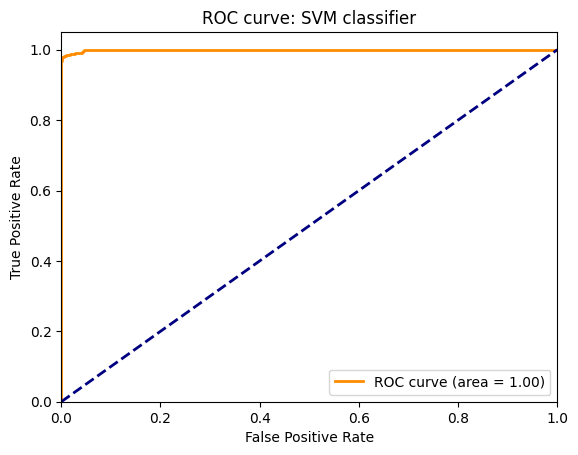

In [ ]:
# ROC curve for all classes

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: SVM classifier")
plt.legend(loc="lower right")
plt.show()

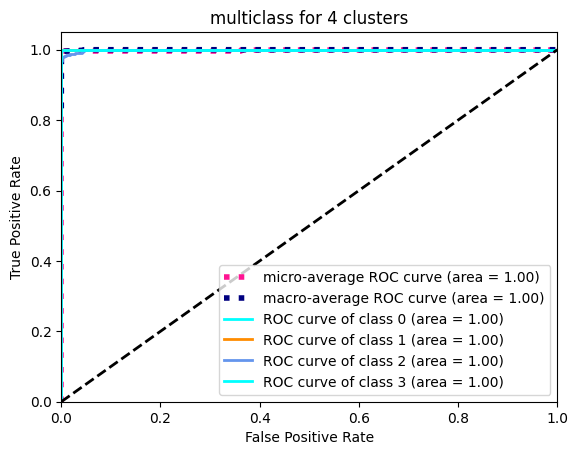

In [ ]:
from itertools import cycle
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("multiclass for 4 clusters")
plt.legend(loc="lower right")
plt.show()

## Part C
Your assignment: Briefly discuss (no code needed) how you would classify the droplets from the assay shown below without using a package algorithm. You can use words or pseudocode to communicate your approach.

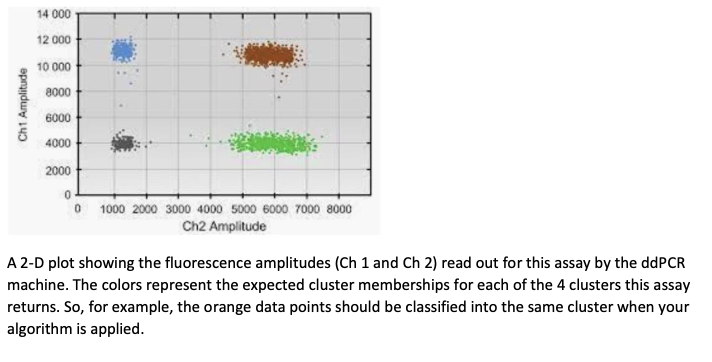 
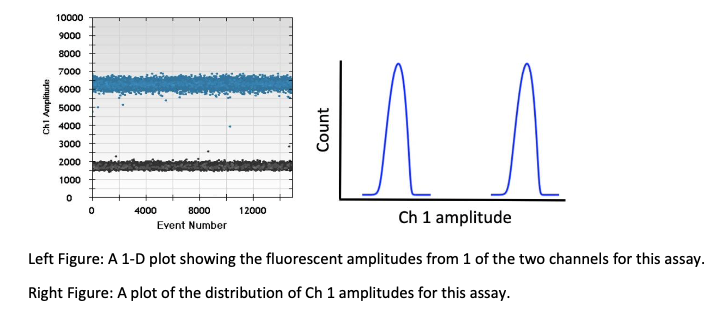

From the distribution of 1-D plot of Ch1 amplitudes, we could expect the Ch1 amplitudes follow Gaussian distribution with two seperate means and variance. The 4 clusters could be grouped by algorithm based on similairty or distance measures between samples. 

For this ddPCR assay, since there are many variables will significant affect the fluorescent amplitudes, design experiments to control those variables, like heterogeneous specimen, machine variance, inheritent variance during each experiment batch etc highly affect the data quality and the prediction accuracy.

Some thought about the experiment design and algorithm

1. each batch introduce concordance control, TAFT control (identify contamination, empty control  and negative control.
2. empty control could help to identify the baseline of fluorescent and remove those empty droplets.  
3. Concordance control with ground truth cluster label. Use those samples as the centroids of each cluster, and group other samples into 4 different clusters based on distance measures algorithm. 

Algorithm design: 

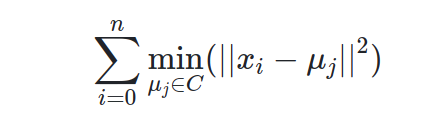

$\mu_j$ = mean(concordance_control), and j = 4 

In [ ]:
# psudocode
## K-Means Clustering 
1. Choose the number of clusters(K) and obtain the data points 
2. Place the centroids c_1, c_2, ..... c_k to concordance control
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
       - find the nearest centroid(c_1, c_2 .. c_k) 
       - assign the point to that cluster 
5. for each cluster j = 1..k
       - new centroid = mean of all points assigned to that cluster
6. End 